In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('data.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749 entries, 0 to 748
Data columns (total 16 columns):
Study Number                        749 non-null int64
Sample ID                           749 non-null object
Product Type                        749 non-null object
Base Ingredient                     640 non-null object
Process Type                        749 non-null object
Sample Age (Weeks)                  749 non-null float64
Difference From Fresh               749 non-null float64
Storage Conditions                  455 non-null object
Packaging Stabilizer Added          467 non-null object
Transparent Window in Package       102 non-null object
Processing Agent Stability Index    749 non-null float64
Preservative Added                  269 non-null object
Moisture (%)                        513 non-null float64
Residual Oxygen (%)                 420 non-null float64
Hexanal (ppm)                       289 non-null float64
Prediction                          0 non-null flo

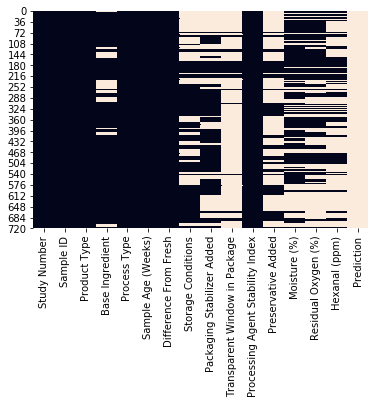

In [7]:
sns.heatmap(data.isnull(), cbar=False)

In [6]:
remove = ['Transparent Window in Package','Prediction','Difference From Fresh']
data = data.drop(remove, axis=1)

In [7]:
missing_values = dict(data.isna().sum().sort_values(ascending=False)/data.shape[0])
missing = data.isna().sum().sort_values(ascending=False)/data.shape[0]

In [1341]:
missing

Preservative Added                  0.640854
Hexanal (ppm)                       0.614152
Residual Oxygen (%)                 0.439252
Storage Conditions                  0.392523
Packaging Stabilizer Added          0.376502
Moisture (%)                        0.315087
Base Ingredient                     0.145527
Processing Agent Stability Index    0.000000
Sample Age (Weeks)                  0.000000
Process Type                        0.000000
Product Type                        0.000000
Sample ID                           0.000000
Study Number                        0.000000
dtype: float64

In [8]:
data.isna().sum().mean()/len(data.index)

0.2249152716442436

In [9]:
missing = pd.DataFrame(missing).reset_index()

In [10]:
no_nan = list(missing[missing[0]==0]['index'])

# To fill NAs in Preservative added

In [11]:
input_data = data[no_nan + ['Preservative Added']]
input_data['Preservative Added'].replace(to_replace=['N', 'Y'], value=[0, 1],inplace=True)

C:\Users\aishw\Anaconda3\envs\fake_news\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [12]:
train = input_data[input_data['Preservative Added'].notnull()]
test = input_data[input_data['Preservative Added'].isnull()]

In [13]:
from sklearn.model_selection import train_test_split

y = train['Preservative Added']
X = train.drop(['Preservative Added'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
print(len(train[train['Preservative Added']==1])*100/len(train.index))
print(len(train[train['Preservative Added']==0])*100/len(train.index))

53.15985130111524
46.84014869888476


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical = X_train.dtypes == object
    
    preprocess = make_column_transformer((StandardScaler(),~categorical),
                                         (OneHotEncoder(handle_unknown='ignore'),categorical),
                                         remainder='passthrough')
    param_lr = {'logisticregression__C': [0.01,0.1,1,10,100] }
    gs_lr = GridSearchCV(estimator=make_pipeline(preprocess,LogisticRegression(class_weight='balanced')),
                         param_grid=param_lr,scoring="accuracy",cv=KFold(shuffle=True))
    gs_lr.fit(X_train,y_train)
    print(gs_lr.best_params_)
    print(gs_lr.best_score_)

{'logisticregression__C': 10}
1.0


In [16]:
y_pred = gs_lr.best_estimator_.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score
def accuracy(y_true, y_pred):
    return(accuracy_score(y_true, y_pred))
    

In [18]:
accuracy(y_test, y_pred)

1.0

In [19]:
test_x = test.drop(['Preservative Added'],axis=1)
test_x['Preservative Added'] = gs_lr.best_estimator_.predict(test_x)

In [20]:
clean_data = pd.concat([train,test_x])
clean_data = clean_data.sort_index(ascending=True)

# To impute hexanal

In [21]:
hex_data = data['Hexanal (ppm)']
input_data = pd.concat([clean_data,hex_data],axis=1)

In [22]:
train = input_data[input_data['Hexanal (ppm)'].notnull()]
test = input_data[input_data['Hexanal (ppm)'].isnull()]

In [23]:
from sklearn.model_selection import train_test_split

y = train['Hexanal (ppm)']
X = train.drop(['Hexanal (ppm)'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical = X_train.dtypes == object
    
    preprocess = make_column_transformer((StandardScaler(),~categorical),
                                         (OneHotEncoder(handle_unknown='ignore'),categorical),
                                         remainder='passthrough')

In [25]:
from sklearn.linear_model import Ridge
est = make_pipeline(preprocess,Ridge(alpha=1.8))
est.fit(X_train,y_train)
pred = est.predict(X_test)

In [26]:
est.score(X_train,y_train)

0.8561676570964412

In [27]:
est.score(X_test,y_test)

0.4795260088947761

In [28]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, pred)

0.09657374573942155

In [29]:
mean_squared_error(y_train, est.predict(X_train))

0.018943433528564365

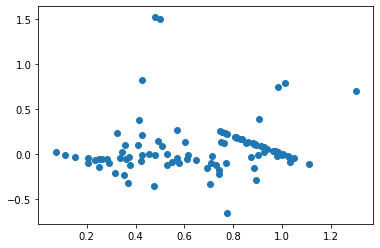

In [30]:
plt.scatter(pred, y_test-pred)

In [31]:
test_pred = est.predict(test.drop(['Hexanal (ppm)'],axis=1))

In [32]:
test_pred.mean()

0.6364407179515812

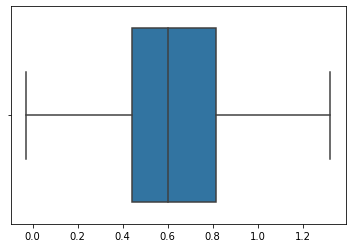

In [33]:
sns.boxplot(test_pred)

In [34]:
test_x = test.drop(['Hexanal (ppm)'],axis=1)
test_x['Hexanal (ppm)'] = test_pred

In [35]:
clean_data = pd.concat([train,test_x])
clean_data = clean_data.sort_index(ascending=True)

In [36]:
clean_data.shape

(749, 8)

In [37]:
data['Hexanal (ppm)'].median()

0.63

In [38]:
clean_data['Hexanal (ppm)'].median()

0.6181192504602347

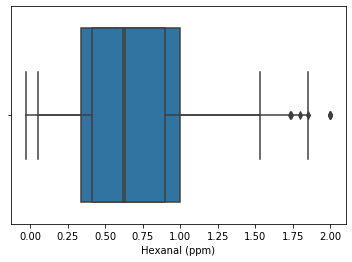

In [39]:
sns.boxplot(data['Hexanal (ppm)'])
sns.boxplot(clean_data['Hexanal (ppm)'])

From the above, we see that after imputing with model, we haven't disturbed the original distribution drastically. So we are good.

# To impute oxygen

In [40]:
oxy_data = data['Residual Oxygen (%)']
input_data = pd.concat([clean_data,oxy_data],axis=1)

In [41]:
train = input_data[input_data['Residual Oxygen (%)'].notnull()]
test = input_data[input_data['Residual Oxygen (%)'].isnull()]

y = train['Residual Oxygen (%)']
X = train.drop(['Residual Oxygen (%)'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical = X_train.dtypes == object
    
    preprocess = make_column_transformer((StandardScaler(),~categorical),
                                         (OneHotEncoder(handle_unknown='ignore'),categorical),
                                         remainder='passthrough')

In [42]:
from sklearn.linear_model import Ridge
est = make_pipeline(preprocess,Ridge(alpha=1))
est.fit(X_train,y_train)
pred = est.predict(X_test)

In [43]:
est.score(X_train,y_train)

0.8773190352292889

In [44]:
est.score(X_test,y_test)

0.8041276877717966

In [45]:
mean_squared_error(y_test, pred)

8.128778517674982

In [46]:
mean_squared_error(y_train, est.predict(X_train))

6.2260039173409485

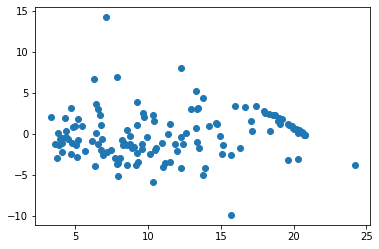

In [47]:
plt.scatter(pred, y_test-pred)

In [48]:
test_pred = est.predict(test.drop(['Residual Oxygen (%)'],axis=1))

In [49]:
test_x = test.drop(['Residual Oxygen (%)'],axis=1)
test_x['Residual Oxygen (%)'] = test_pred

In [50]:
clean_data = pd.concat([train,test_x])
clean_data = clean_data.sort_index(ascending=True)

In [51]:
clean_data.shape

(749, 9)

# to impute storage conditions

From the subject, we know that storage conditions would depend on base ingredient, product type and process type. Hence use a decision tree based model to fill these missing values.

In [52]:
data['Storage Conditions'].unique()

array([nan, 'Warm Climate', 'High Temperature and Humidity',
       'Cold Climate'], dtype=object)

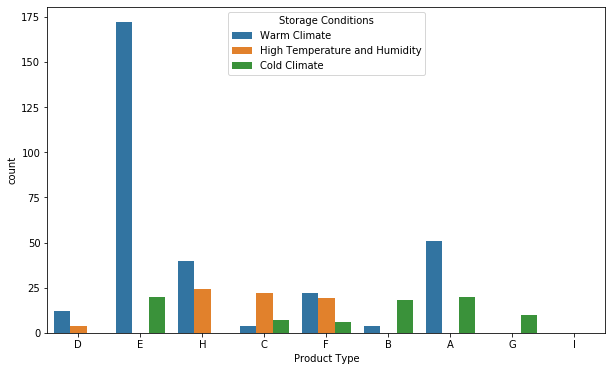

In [53]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(hue='Storage Conditions', x="Product Type", data=data)

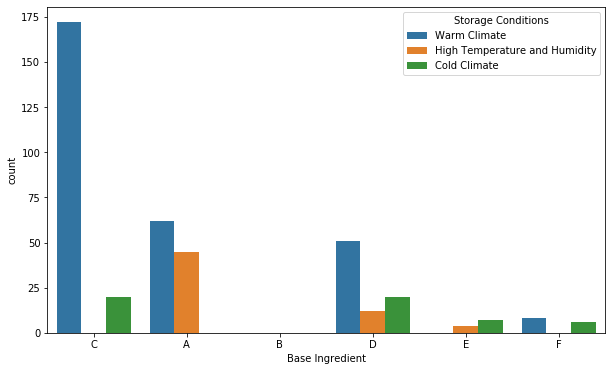

In [54]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(hue='Storage Conditions', x="Base Ingredient", data=data)

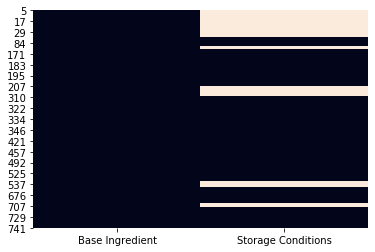

In [55]:
view = data[data['Base Ingredient'] == 'C'][['Base Ingredient','Storage Conditions']]
sns.heatmap(view.isnull(), cbar=False)

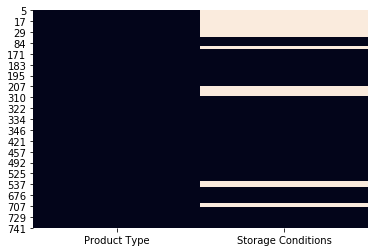

In [56]:
view = data[data['Product Type'] == 'E'][['Product Type','Storage Conditions']]
sns.heatmap(view.isnull(), cbar=False)

In [57]:
sc_data = data['Storage Conditions']
input_data = pd.concat([clean_data,sc_data],axis=1)

In [58]:
factor = pd.factorize(input_data['Storage Conditions'])

In [59]:
input_data['Storage Conditions'] = factor[0]

In [60]:
input_data['Storage Conditions'].unique()

array([-1,  0,  1,  2], dtype=int64)

In [61]:
train = input_data[input_data['Storage Conditions'] != -1]
test = input_data[input_data['Storage Conditions'] == -1]

y = train['Storage Conditions']
X = train.drop(['Storage Conditions'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical = X_train.dtypes == object
    
    preprocess = make_column_transformer((StandardScaler(),~categorical),
                                         (OneHotEncoder(handle_unknown='ignore'),categorical),
                                         remainder='passthrough')

In [62]:
from sklearn.ensemble import RandomForestClassifier
est = make_pipeline(preprocess,RandomForestClassifier())
est.fit(X_train,y_train)
pred = est.predict(X_test)

C:\Users\aishw\Anaconda3\envs\fake_news\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [64]:
est.score(X_train,y_train)

1.0

In [65]:
est.score(X_test,y_test)

0.9933774834437086

In [66]:
test_pred = est.predict(test.drop(['Storage Conditions'],axis=1))
test_x = test.drop(['Storage Conditions'],axis=1)
test_x['Storage Conditions'] = test_pred

In [67]:
clean_data = pd.concat([train,test_x])
clean_data = clean_data.sort_index(ascending=True)

In [68]:
clean_data.shape

(749, 10)

In [69]:
clean_data['Storage Conditions'] = clean_data['Storage Conditions'].astype(object)

# To impute packaging stablizer

In [70]:
ps_data = data['Packaging Stabilizer Added']
input_data = pd.concat([clean_data,ps_data],axis=1)

In [71]:
train = input_data[input_data['Packaging Stabilizer Added'].notnull()]
test = input_data[input_data['Packaging Stabilizer Added'].isnull()]

y = train['Packaging Stabilizer Added']
X = train.drop(['Packaging Stabilizer Added'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical = X_train.dtypes == object
    
    preprocess = make_column_transformer((StandardScaler(),~categorical),
                                         (OneHotEncoder(handle_unknown='ignore'),categorical),
                                         remainder='passthrough')

In [72]:
from sklearn.ensemble import RandomForestClassifier
est = make_pipeline(preprocess,RandomForestClassifier())
est.fit(X_train,y_train)
pred = est.predict(X_test)

C:\Users\aishw\Anaconda3\envs\fake_news\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [79]:
est.score(X_train,y_train)

0.9967948717948718

In [80]:
est.score(X_test,y_test)

0.9870967741935484

In [81]:
test_pred = est.predict(test.drop(['Packaging Stabilizer Added'],axis=1))
test_x = test.drop(['Packaging Stabilizer Added'],axis=1)
test_x['Packaging Stabilizer Added'] = test_pred

clean_data = pd.concat([train,test_x])
clean_data = clean_data.sort_index(ascending=True)

In [82]:
clean_data.shape

(749, 11)

# To impute moisture %

In [83]:
m_data = data['Moisture (%)']
input_data = pd.concat([clean_data,m_data],axis=1)

In [84]:
train = input_data[input_data['Moisture (%)'].notnull()]
test = input_data[input_data['Moisture (%)'].isnull()]

y = train['Moisture (%)']
X = train.drop(['Moisture (%)'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical = X_train.dtypes == object
    
    preprocess = make_column_transformer((StandardScaler(),~categorical),
                                         (OneHotEncoder(handle_unknown='ignore'),categorical),
                                         remainder='passthrough')

In [85]:
from sklearn.linear_model import Ridge
est = make_pipeline(preprocess,Ridge(alpha=0.01))
est.fit(X_train,y_train)
pred = est.predict(X_test)

In [86]:
est.score(X_train,y_train)

0.8454415417944389

In [87]:
est.score(X_test,y_test)

0.9474195051305178

In [88]:
mean_squared_error(y_test, pred)

0.24357698832004177

In [89]:
mean_squared_error(y_train, est.predict(X_train))

0.7248563070123428

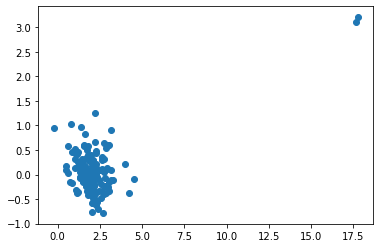

In [90]:
plt.scatter(pred, y_test-pred)

In [91]:
test_pred = est.predict(test.drop(['Moisture (%)'],axis=1))
test_x = test.drop(['Moisture (%)'],axis=1)
test_x['Moisture (%)'] = test_pred

In [92]:
clean_data = pd.concat([train,test_x])
clean_data = clean_data.sort_index(ascending=True)
clean_data.shape

(749, 12)

# To impute base ingredient

In [93]:
BI_data = data['Base Ingredient']
input_data = pd.concat([clean_data,BI_data],axis=1)

train = input_data[input_data['Base Ingredient'].notnull()]
test = input_data[input_data['Base Ingredient'].isnull()]

y = train['Base Ingredient']
X = train.drop(['Base Ingredient'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical = X_train.dtypes == object
    
    preprocess = make_column_transformer((StandardScaler(),~categorical),
                                         (OneHotEncoder(handle_unknown='ignore'),categorical),
                                         remainder='passthrough')

In [94]:
from sklearn.ensemble import RandomForestClassifier
est = make_pipeline(preprocess,RandomForestClassifier())
est.fit(X_train,y_train)
pred = est.predict(X_test)

C:\Users\aishw\Anaconda3\envs\fake_news\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [95]:
est.score(X_train,y_train)

1.0

In [96]:
est.score(X_test,y_test)

0.9952830188679245

In [97]:
test_pred = est.predict(test.drop(['Base Ingredient'],axis=1))
test_x = test.drop(['Base Ingredient'],axis=1)
test_x['Base Ingredient'] = test_pred

In [98]:
clean_data = pd.concat([train,test_x])
clean_data = clean_data.sort_index(ascending=True)

In [99]:
clean_data.shape

(749, 13)

In [100]:
data.shape

(749, 13)

In [101]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 749 entries, 0 to 748
Data columns (total 13 columns):
Processing Agent Stability Index    749 non-null float64
Sample Age (Weeks)                  749 non-null float64
Process Type                        749 non-null object
Product Type                        749 non-null object
Sample ID                           749 non-null object
Study Number                        749 non-null int64
Preservative Added                  749 non-null float64
Hexanal (ppm)                       749 non-null float64
Residual Oxygen (%)                 749 non-null float64
Storage Conditions                  749 non-null object
Packaging Stabilizer Added          749 non-null object
Moisture (%)                        749 non-null float64
Base Ingredient                     749 non-null object
dtypes: float64(6), int64(1), object(6)
memory usage: 81.9+ KB


# Building actual model with clean data

In [102]:
data = pd.read_csv('data.csv')

y = list(data['Difference From Fresh'])
y_c = []
fresh = 0
not_fresh = 0
for val in y:
    if val > 20:
        # not fresh
        y_c.append(0)
        not_fresh = not_fresh + 1
    if val <= 20:
        # fresh
        y_c.append(1)
        fresh = fresh + 1

In [103]:
print(not_fresh)
print(fresh)

145
604


In [104]:
X = clean_data

In [1435]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 749 entries, 0 to 748
Data columns (total 13 columns):
Processing Agent Stability Index    749 non-null float64
Sample Age (Weeks)                  749 non-null float64
Process Type                        749 non-null object
Product Type                        749 non-null object
Sample ID                           749 non-null object
Study Number                        749 non-null int64
Preservative Added                  749 non-null float64
Hexanal (ppm)                       749 non-null float64
Residual Oxygen (%)                 749 non-null float64
Storage Conditions                  749 non-null object
Packaging Stabilizer Added          749 non-null object
Moisture (%)                        749 non-null float64
Base Ingredient                     749 non-null object
dtypes: float64(6), int64(1), object(6)
memory usage: 81.9+ KB


# Baseline prediction model - simple imputation

In [1159]:
from sklearn.impute import SimpleImputer

def prep_train_data(X_train):
    X_train_cont = X_train.select_dtypes(exclude=['object'])
    X_train_cat = X_train.select_dtypes(include=['object'])

    cont_cols = X_train_cont.columns
    cat_cols = X_train_cat.columns

    imp = SimpleImputer(strategy="median").fit(X_train_cont)
    X_train_cont = imp.transform(X_train_cont)
    X_train_cont = pd.DataFrame(X_train_cont,columns=cont_cols)

    imp1 = SimpleImputer(strategy="most_frequent").fit(X_train_cat)
    X_train_cat = imp1.transform(X_train_cat)
    X_train_cat = pd.DataFrame(X_train_cat,columns=cat_cols)

    for col in X_train_cat.columns:
        X_train_cont[col] = X_train_cat[col]

    X_train_final = X_train_cont
    X_train_dummies = pd.get_dummies(X_train_final)
    
    return X_train_dummies, X_train_cat, imp, imp1


In [ ]:
def prep_test_data(X_test, X_train_cat, imp,imp1):
    X_test_cont = X_test.select_dtypes(exclude=['object'])
    X_test_cat = X_test.select_dtypes(include=['object'])

    cont_cols = X_test_cont.columns
    cat_cols = X_test_cat.columns

    X_test_cont = imp.transform(X_test_cont)
    X_test_cont = pd.DataFrame(X_test_cont,columns=cont_cols)

    X_test_cat = imp1.transform(X_test_cat)
    X_test_cat = pd.DataFrame(X_test_cat,columns=cat_cols)

    for col in X_test_cat.columns:
        X_test_cont[col] = X_test_cat[col]

    X_test_final = X_test_cont
    X_test_dummies = pd.get_dummies(X_test_final)
    Process_Type = X_train_cat['Process Type'].unique()
    Product_Type = X_train_cat['Product Type'].unique()
    Sample_ID = X_train_cat['Sample ID'].unique()
    Storage_Conditions = X_train_cat['Storage Conditions'].unique()
    Packaging_Stabilizer_Added = X_train_cat['Packaging Stabilizer Added'].unique()
    Base_Ingredient = X_train_cat['Base Ingredient'].unique()
    
    X_test_final['Process Type'] = pd.Categorical(X_test_final['Process Type'], categories = Process_Type)
    X_test_final['Product Type'] = pd.Categorical(X_test_final['Product Type'], categories = Product_Type)
    X_test_final['Sample ID'] = pd.Categorical(X_test_final['Sample ID'], categories = Sample_ID)
    X_test_final['Storage Conditions'] = pd.Categorical(X_test_final['Storage Conditions'], categories = Storage_Conditions)
    X_test_final['Packaging Stabilizer Added'] = pd.Categorical(X_test_final['Packaging Stabilizer Added'], categories = Packaging_Stabilizer_Added)
    X_test_final['Base Ingredient'] = pd.Categorical(X_test_final['Base Ingredient'], categories = Base_Ingredient)
    
    X_test_dummies = pd.get_dummies(X_test_final)
    
    return X_test_dummies

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Difference From Fresh','Prediction'],axis=1), 
                                                    y, test_size=0.33, random_state=42)

In [1146]:
from sklearn.linear_model import LinearRegression
X_train_dummies,X_train_cat,imp, imp1 = prep_train_data(X_train)
X_test_dummies = prep_test_data(X_test,X_train_cat,imp,imp1)
est = LinearRegression().fit(X_train_dummies,y_train)

In [1134]:
pred = est.predict(X_test_dummies)

In [1135]:
mean_squared_error(y_test, pred)

4.796783064737544e+16

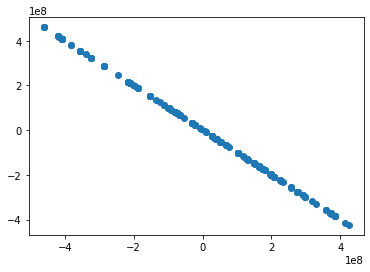

In [1136]:
plt.scatter(pred, y_test-pred)

# Baseline classification model - Simple Imputation

In [1164]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Difference From Fresh','Prediction'],axis=1), 
                                                    y_c, test_size=0.33, random_state=42)
X_train_dummies,X_train_cat,imp, imp1 = prep_train_data(X_train)
X_test_dummies = prep_test_data(X_test,X_train_cat,imp,imp1)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    param_lr = {'logisticregression__C': [1, 5, 7, 10, 25, 50, 100] }
    
    gs_lr = GridSearchCV(estimator=make_pipeline(LogisticRegression()),
                         param_grid=param_lr,scoring="roc_auc",cv=KFold(shuffle=True))
    
    gs_lr.fit(X_train_dummies,y_train)
    print(gs_lr.best_params_)
    print(gs_lr.best_score_)

{'logisticregression__C': 1}
0.440272906828884


In [1165]:
from sklearn.metrics import f1_score
f1_score(y_test, gs_lr.best_estimator_.predict(X_test_dummies))  

0.8977777777777779

# Fit linear regression as baseline model for clean data

In [1315]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [1316]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 749 entries, 0 to 748
Data columns (total 13 columns):
Processing Agent Stability Index    749 non-null float64
Sample Age (Weeks)                  749 non-null float64
Process Type                        749 non-null object
Product Type                        749 non-null object
Sample ID                           749 non-null object
Study Number                        749 non-null int64
Preservative Added                  749 non-null float64
Hexanal (ppm)                       749 non-null float64
Residual Oxygen (%)                 749 non-null float64
Storage Conditions                  749 non-null object
Packaging Stabilizer Added          749 non-null object
Moisture (%)                        749 non-null float64
Base Ingredient                     749 non-null object
dtypes: float64(6), int64(1), object(6)
memory usage: 81.9+ KB


In [1440]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical = X_train.dtypes == object
    
    preprocess = make_column_transformer((StandardScaler(),~categorical),
                                         (OneHotEncoder(handle_unknown='ignore'),categorical),
                                         remainder='passthrough')

In [1318]:
from sklearn.linear_model import LinearRegression
est = make_pipeline(preprocess,LinearRegression())
est.fit(X_train,y_train)
pred = est.predict(X_test)

In [1319]:
est.score(X_train,y_train)

0.6498756462126644

In [1320]:
est.score(X_test,y_test)

-0.02741332179257938

In [1321]:
mean_squared_error(y_test, pred)

137.457195166616

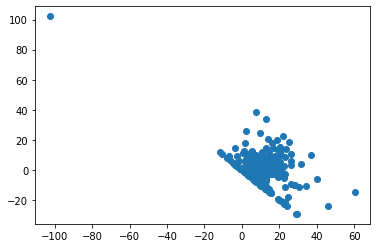

In [1322]:
plt.scatter(pred, y_test-pred)

As can be seen, linear regression did not perform well. However, this is a baseline to start with.

# Ridge Regression

In [1025]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    param_lr = {'ridge__alpha': [0.01,0.1,0.5,1,2,3,10] }
    gs_lr = GridSearchCV(estimator=make_pipeline(preprocess,Ridge()),
                         param_grid=param_lr,cv=KFold(shuffle=True))
    
    gs_lr.fit(X_train,y_train)
    
    print(gs_lr.best_params_)
    print(gs_lr.best_score_)

{'ridge__alpha': 3}
0.3341808685276884


In [1026]:
est = gs_lr.best_estimator_

In [1027]:
est.score(X_test,y_test)

0.3794236281610639

In [1028]:
mean_squared_error(y_test, gs_lr.best_estimator_.predict(X_test))

83.02665115420466

Ridge is way better than linear regression

# Lasso Regression

In [1029]:
from sklearn.linear_model import Lasso
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    param_lr = {'lasso__alpha': [0.01,0.1,0.5,1,2,3] }
    gs_lr = GridSearchCV(estimator=make_pipeline(preprocess,Lasso()),
                         param_grid=param_lr,cv=KFold(shuffle=True))
    
    gs_lr.fit(X_train,y_train)
    
    print(gs_lr.best_params_)
    print(gs_lr.best_score_)

{'lasso__alpha': 0.01}
0.3156197039336406


In [1030]:
mean_squared_error(y_test, gs_lr.best_estimator_.predict(X_test))

88.69728917128495

Lasso is just in par with ridge. Let us look at random forest.

# Random forest regressor

In [1329]:
from sklearn.ensemble import RandomForestRegressor
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    param_lr = {'randomforestregressor__n_estimators': [10,30,50,100,150,300] }
    gs_lr = GridSearchCV(estimator=make_pipeline(preprocess,RandomForestRegressor()),
                         param_grid=param_lr,cv=KFold(shuffle=True))
    
    gs_lr.fit(X_train,y_train)
    
    print(gs_lr.best_params_)
    print(gs_lr.best_score_)

{'randomforestregressor__n_estimators': 100}
0.5289044126418931


In [1330]:
mean_squared_error(y_test, gs_lr.best_estimator_.predict(X_test))

55.708928116935496

In [1331]:
final_pred = gs_lr.best_estimator_.predict(X)
X['final_pred'] = final_pred

In [1333]:
X.to_csv('res_pred.csv')

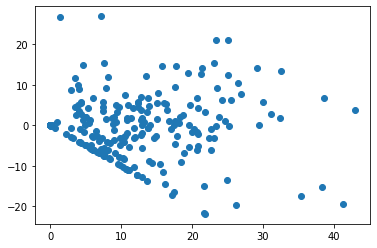

In [1325]:
pred = gs_lr.best_estimator_.predict(X_test)
plt.scatter(pred, y_test-pred)

In [1326]:
feat_imp = gs_lr.best_estimator_.named_steps['randomforestregressor'].feature_importances_

In [1327]:
def get_feat_imp(best_est,feat_imp):
    cat_list = best_est.named_steps['columntransformer'].named_transformers_['onehotencoder'].categories_
    flat_list = [item for cat_list in cat_list for item in cat_list]
    cont = X_train.select_dtypes(exclude=['object'])
    tot_col = list(cont.columns)
    tot_col.extend(flat_list)
    df = pd.DataFrame({'cat':tot_col,'feat_imp':feat_imp})
    return df.reindex(df.feat_imp.abs().sort_values(ascending = False).index)

res = get_feat_imp(gs_lr.best_estimator_,feat_imp)
res

,cat,feat_imp
1,Sample Age (Weeks),0.241650
4,Hexanal (ppm),0.139371
6,Moisture (%),0.118986
5,Residual Oxygen (%),0.100893
2,Study Number,0.094585
...,...,...
41,1411909-1,0.000043
55,1512305-2,0.000037
75,1513103-1,0.000031
29,1310957-1,0.000029


Text(0.5, 1.0, 'features Vs Importances')

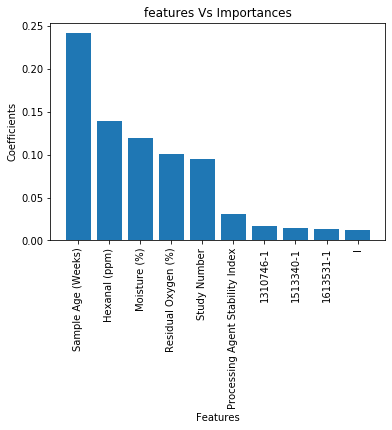

In [1328]:
plt.xticks(rotation=90)
plt.bar(res.iloc[:10,0],res.iloc[:10,1])
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.title("features Vs Importances")

# XGBoost regressor

In [1037]:
from sklearn import ensemble
from sklearn.model_selection import RandomizedSearchCV

params = {'n_estimators': [100,200,300], 'max_depth': [4,5,6,7]}
clf = ensemble.GradientBoostingRegressor()

random_search = RandomizedSearchCV(clf, param_distributions=params,n_iter=5,
                                   n_jobs=4,verbose=3, random_state=42 )

random_search.fit(preprocess.fit_transform(X_train), y_train)

C:\Users\aishw\Anaconda3\envs\fake_news\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    9.7s finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                       

In [1039]:
preprocess.fit(X_train)
mean_squared_error(y_test, random_search.best_estimator_.predict(preprocess.transform(X_test)))

59.88792388094287

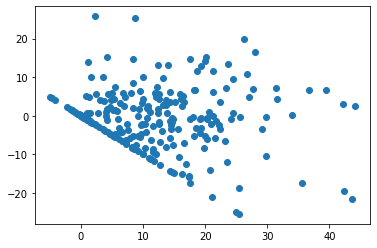

In [1045]:
pred = random_search.best_estimator_.predict(preprocess.transform(X_test))
plt.scatter(pred, y_test-pred)

# SVR

In [1042]:
from sklearn.svm import SVR
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    param_lr = {'svr__C': [0.01,0.1,1,10,100,1000] }
    gs_lr = GridSearchCV(estimator=make_pipeline(preprocess,SVR()),
                         param_grid=param_lr,cv=KFold(shuffle=True))
    
    gs_lr.fit(X_train,y_train)
    
    print(gs_lr.best_params_)
    print(gs_lr.best_score_)

{'svr__C': 100}
0.3360720771785603


In [1043]:
mean_squared_error(y_test, gs_lr.best_estimator_.predict(X_test))

90.47950720875014

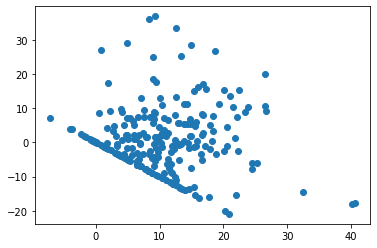

In [1044]:
pred = gs_lr.best_estimator_.predict(X_test)
plt.scatter(pred, y_test-pred)

# Try polynomial features

In [865]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

est = make_pipeline(preprocess,PolynomialFeatures(2),LinearRegression())
est.fit(X_train,y_train)
pred = est.predict(X_test)

In [866]:
est.score(X_test,y_test)

-523.1001633079292

In [880]:
mean_squared_error(y_test, pred)

70119.13988907523

# Classification approach

In [105]:
X_train, X_test, y_train, y_test = train_test_split(clean_data, y_c, test_size=0.33, random_state=42)

In [106]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical = X_train.dtypes == object
    
    preprocess = make_column_transformer((StandardScaler(),~categorical),
                                         (OneHotEncoder(handle_unknown='ignore'),categorical),
                                         remainder='passthrough')

In [107]:
X_train.shape

(501, 13)

In [1447]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 749 entries, 0 to 748
Data columns (total 13 columns):
Processing Agent Stability Index    749 non-null float64
Sample Age (Weeks)                  749 non-null float64
Process Type                        749 non-null object
Product Type                        749 non-null object
Sample ID                           749 non-null object
Study Number                        749 non-null int64
Preservative Added                  749 non-null float64
Hexanal (ppm)                       749 non-null float64
Residual Oxygen (%)                 749 non-null float64
Storage Conditions                  749 non-null object
Packaging Stabilizer Added          749 non-null object
Moisture (%)                        749 non-null float64
Base Ingredient                     749 non-null object
dtypes: float64(6), int64(1), object(6)
memory usage: 81.9+ KB


In [1448]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    param_lr = {'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100] }
    
    gs_lr = GridSearchCV(estimator=make_pipeline(preprocess,LogisticRegression()),
                         param_grid=param_lr,scoring="roc_auc",cv=KFold(shuffle=True))
    
    gs_lr.fit(X_train,y_train)
    print(gs_lr.best_params_)
    print(gs_lr.best_score_)

{'logisticregression__C': 10}
0.8189373673582991


In [1449]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, gs_lr.best_estimator_.predict(X_test))

array([[ 20,  26],
       [ 15, 187]], dtype=int64)

This is indeed a good baseline.

# Random forest classifier

In [1441]:
from sklearn.ensemble import RandomForestClassifier
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    param_lr = {'randomforestclassifier__n_estimators': [10,30,50,100,150,300] }
    gs_lr = GridSearchCV(estimator=make_pipeline(preprocess,RandomForestClassifier(class_weight="balanced")),
                         scoring='roc_auc',
                         param_grid=param_lr,cv=KFold(shuffle=True))
    
    gs_lr.fit(X_train,y_train)
    
    print(gs_lr.best_params_)
    print(gs_lr.best_score_)

{'randomforestclassifier__n_estimators': 150}
0.8700145658478993


In [1442]:
confusion_matrix(y_test, gs_lr.best_estimator_.predict(X_test))

array([[ 24,  22],
       [ 16, 186]], dtype=int64)

In [1443]:
tn, fp, fn, tp = confusion_matrix(y_test, gs_lr.best_estimator_.predict(X_test)).ravel()
print(tn, fp, fn, tp)

24 22 16 186


In [1203]:
accuracy_score(y_test, gs_lr.best_estimator_.predict(X_test))

0.8508064516129032

In [1204]:
f1_score(y_test, gs_lr.best_estimator_.predict(X_test))

0.9099756690997567

In [1205]:
final_pred = gs_lr.best_estimator_.predict(X)

In [1207]:
X['pred'] = final_pred
X.to_csv('res_class.csv')

In [1195]:
feat_imp = gs_lr.best_estimator_.named_steps['randomforestclassifier'].feature_importances_

def get_feat_imp(best_est,feat_imp):
    cat_list = best_est.named_steps['columntransformer'].named_transformers_['onehotencoder'].categories_
    flat_list = [item for cat_list in cat_list for item in cat_list]
    cont = X_train.select_dtypes(exclude=['object'])
    tot_col = list(cont.columns)
    tot_col.extend(flat_list)
    df = pd.DataFrame({'cat':tot_col,'feat_imp':feat_imp})
    return df.reindex(df.feat_imp.abs().sort_values(ascending = False).index)

res = get_feat_imp(gs_lr.best_estimator_,feat_imp)
res

,cat,feat_imp
6,Moisture (%),0.142566
5,Residual Oxygen (%),0.137491
1,Sample Age (Weeks),0.123113
4,Hexanal (ppm),0.118211
2,Study Number,0.083993
...,...,...
123,1715394-1,0.000071
81,1513327-1,0.000051
76,1513115-1,0.000051
54,1512305-1,0.000002


Text(0.5, 1.0, 'features Vs Importances')

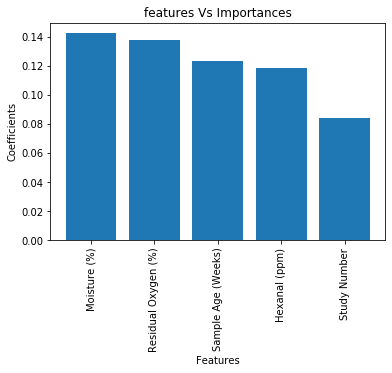

In [1196]:
plt.xticks(rotation=90)
plt.bar(res.iloc[:5,0],res.iloc[:5,1])
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.title("features Vs Importances")

# Ada Boost classifier

In [1192]:
from sklearn.ensemble import AdaBoostClassifier
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    param_ada = {'adaboostclassifier__n_estimators': [3,5,10,30,50,100,150,300] }
    gs_ada = GridSearchCV(estimator=make_pipeline(preprocess,AdaBoostClassifier()),scoring='roc_auc',
                         param_grid=param_ada,cv=KFold(shuffle=True))
    
    gs_ada.fit(X_train,y_train)
    
    print(gs_ada.best_params_)
    print(gs_ada.best_score_)

{'adaboostclassifier__n_estimators': 30}
0.7943786199164928


In conclusion, Random forest regressor and classifier work well on this data. The AUC with the best model is 0.86 and MSE is 57.8.